# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import napari
from macrohet import dataio, tile
import btrack
print(btrack.__version__)
import os

0.6.1.dev30


### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [4]:
row = 3
column = 5

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [5]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
#                              set_channel=1,
#                              set_time = 66,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()

In [6]:
%%time
images = images.compute().compute()

CPU times: user 2h 56min 10s, sys: 16min 58s, total: 3h 13min 9s
Wall time: 10min 29s


In [9]:
images.shape

(75, 2, 6048, 6048)

# Load tracks

In [10]:
tracks_fn = os.path.join(base_dir, f'labels/macrohet_seg_model/{row, column}.h5')
with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
    tracks = hdf.tracks
    segmentation = hdf.segmentation
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)

[INFO][2023/05/17 08:05:07 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/05/17 08:05:07 AM] Loading tracks/obj_type_1
[INFO][2023/05/17 08:05:07 AM] Loading LBEP/obj_type_1
[INFO][2023/05/17 08:05:07 AM] Loading objects/obj_type_1 (42040, 5) (42040 filtered: None)
[INFO][2023/05/17 08:05:20 AM] Loading segmentation (75, 6048, 6048)
[INFO][2023/05/17 08:05:20 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


In [11]:
segmentation.shape

(75, 6048, 6048)

In [16]:
napari_tracks

array([[1.00000000e+00, 0.00000000e+00, 8.79328674e+02, 2.07035736e+02],
       [1.00000000e+00, 1.00000000e+00, 8.80479919e+02, 2.07722641e+02],
       [1.00000000e+00, 2.00000000e+00, 8.77041504e+02, 2.12970306e+02],
       ...,
       [3.94100000e+03, 7.40000000e+01, 1.02795764e+03, 5.36334534e+02],
       [3.94600000e+03, 7.40000000e+01, 4.41559219e+00, 4.76425537e+02],
       [3.94700000e+03, 7.40000000e+01, 5.38811646e+02, 6.17515137e+02]])

### Load downscaled version

In [12]:
tracks_fn = os.path.join(base_dir, f'labels/full_localisation/downscaled/{row,column}_downsc_objs_masks_tracks.h5')
with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
    ds_tracks = hdf.tracks
    ds_segmentation = hdf.segmentation
ds_napari_tracks, properties, graph = btrack.utils.tracks_to_napari(ds_tracks, ndim=2)

[INFO][2023/05/17 08:05:24 AM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 5)_downsc_objs_masks_tracks.h5...
[INFO][2023/05/17 08:05:24 AM] Loading tracks/obj_type_1
[INFO][2023/05/17 08:05:24 AM] Loading LBEP/obj_type_1
[INFO][2023/05/17 08:05:24 AM] Loading objects/obj_type_1 (26917, 5) (26917 filtered: None)
[INFO][2023/05/17 08:05:26 AM] Loading segmentation (75, 1200, 1200)
[INFO][2023/05/17 08:05:26 AM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 5)_downsc_objs_masks_tracks.h5


### Load retracked version

In [43]:
with btrack.io.HDF5FileHandler(os.path.join(base_dir, f'labels/relocalisation/relocalised_{row, column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
            tracks = reader.tracks
            objects = reader.objects
            segmentation = reader.segmentation
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)
filtered_napari_tracks, properties, graph = btrack.utils.tracks_to_napari([t for t in tracks if len(t)>10], ndim=2)

[INFO][2023/05/17 10:14:16 am] Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(3, 5).h5...
17-May-23 10:14:16 - btrack.io.hdf - INFO     - Opening HDF file: /mnt/DATA/macrohet/labels/relocalisation/relocalised_(3, 5).h5...
[INFO][2023/05/17 10:14:16 am] Loading tracks/obj_type_1
17-May-23 10:14:16 - btrack.io.hdf - INFO     - Loading tracks/obj_type_1
[INFO][2023/05/17 10:14:16 am] Loading LBEP/obj_type_1
17-May-23 10:14:16 - btrack.io.hdf - INFO     - Loading LBEP/obj_type_1
[INFO][2023/05/17 10:14:16 am] Loading objects/obj_type_1 (28787, 5) (28787 filtered: None)
17-May-23 10:14:16 - btrack.io.hdf - INFO     - Loading objects/obj_type_1 (28787, 5) (28787 filtered: None)
[INFO][2023/05/17 10:14:17 am] Loading objects/obj_type_1 (28787, 5) (28787 filtered: None)
17-May-23 10:14:17 - btrack.io.hdf - INFO     - Loading objects/obj_type_1 (28787, 5) (28787 filtered: None)
[INFO][2023/05/17 10:14:27 am] Loading segmentation (75, 6048, 6048)
17-May-23 10:14:27 - btr

### Recolour tracks

In [45]:
col_segmentation = btrack.utils.update_segmentation(segmentation, [t for t in tracks if len(t)>10], scale = (5.04, 5.04))

In [14]:
ds_col_segmentation = btrack.utils.update_segmentation(ds_segmentation, ds_tracks,)# scale = (5.04, 5.04))

# Launch napari image viewer

In [48]:
viewer = napari.Viewer()

viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green",  "magenta"],
#                  contrast_limits=[[100, 6000], [100, 2000]],
                 contrast_limits=[[0,450], [0,450]], 
                 visible = False
                 )
viewer.add_labels(segmentation, 
#                   num_colors= 1,
                  #scale=(10, 1, 1,), 
                  #color='yellow'
                  name = 'new segmentation'
                 )
viewer.add_labels(col_segmentation, 
                  name = 'recolored new segmentation'
                  #scale=(10, 1, 1,), 
                  #color='yellow'
                 )
viewer.add_tracks(napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
                    name="New model tracks", 
                    blending="translucent",
                    visible=True,
                    scale = (1,5.04,5.04)
                 )
viewer.add_tracks(filtered_napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
                    name="New model tracks", 
                    blending="translucent",
                    visible=True,
                    scale = (1,5.04,5.04)
                 )
viewer.add_tracks(ds_napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
                    name="downscaled tracks", 
                    blending="translucent",
                    visible=True,
#                     scale = (1,1,1)
                )
viewer.add_labels(ds_segmentation, 
                 name = 'downscaled segmentation')

viewer.add_labels(ds_col_segmentation, 
                  name = 'downscaled coloured segmentation',
                  scale=(1, 1, 1,), 
#                   color={1:'yellow'}
                 )


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'downscaled coloured segmentation' at 0x7f2cd17d44c0>

# Checking to see if object filter excludes some segments

In [23]:
tracks_fn = os.path.join(base_dir, f'labels/macrohet_seg_model/{row, column}.h5')
with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
    objects = hdf.objects

[INFO][2023/05/17 08:39:02 am] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
17-May-23 08:39:02 - btrack.io.hdf - INFO     - Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/05/17 08:39:02 am] Loading objects/obj_type_1 (42040, 5) (42040 filtered: None)
17-May-23 08:39:02 - btrack.io.hdf - INFO     - Loading objects/obj_type_1 (42040, 5) (42040 filtered: None)
[INFO][2023/05/17 08:39:03 am] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
17-May-23 08:39:03 - btrack.io.hdf - INFO     - Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5


In [26]:
import matplotlib.pyplot as plt

(array([ 72., 158., 128.,  82.,  73.,  54.,  25.,  19.,   9.,   9.,   4.,
          5.,   4.,   3.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1644. ,  11054.8,  20465.6,  29876.4,  39287.2,  48698. ,
         58108.8,  67519.6,  76930.4,  86341.2,  95752. , 105162.8,
        114573.6, 123984.4, 133395.2, 142806. , 152216.8, 161627.6,
        171038.4, 180449.2, 189860. , 199270.8, 208681.6, 218092.4,
        227503.2, 236914. , 246324.8, 255735.6, 265146.4, 274557.2,
        283968. ], dtype=float32),
 <BarContainer object of 30 artists>)

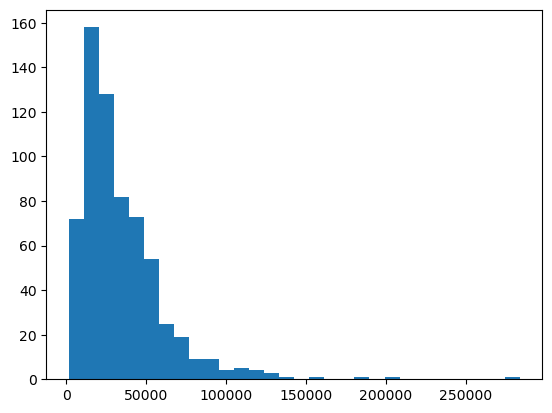

In [30]:
plt.hist([o.properties['area'] for o in objects if o.t == 0], bins = 30)


In [33]:
min([o.properties['area'] for o in objects if o.t == 0])

1644.0

In [35]:
[o for o in objects if o.properties['area'] == 1644.0][0]

,ID,x,y,z,t,dummy,states,label,major_axis_length,minor_axis_length,area,orientation,mean_intensity
0,18937,41.256927,1008.311462,0.0,0,False,7,5,54.222641,38.736034,1644.0,-1.375424,"(2,) array"


In [37]:
1008*5.04

5080.32

(0.0, 25000.0)

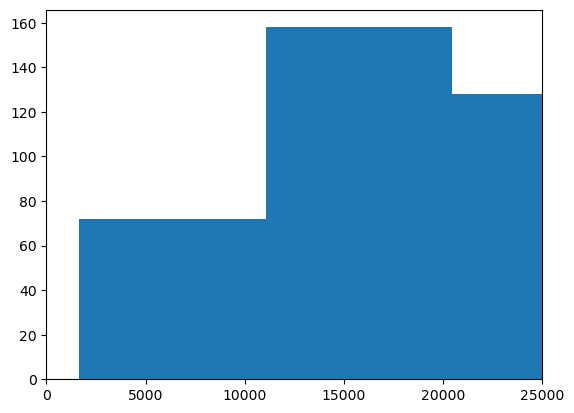

In [31]:
plt.hist([o.properties['area'] for o in objects if o.t == 0], bins = 30)
plt.xlim(0,25000)

In [41]:
[track for track in tracks if track.ID == 571][0].properties['area']

array([2621.], dtype=float32)

In [40]:
435*5.04

2192.4

(array([1290.,  292.,  210.,  125.,  110.,  103.,   72.,   60.,   44.,
         224.]),
 array([ 1. ,  8.4, 15.8, 23.2, 30.6, 38. , 45.4, 52.8, 60.2, 67.6, 75. ]),
 <BarContainer object of 10 artists>)

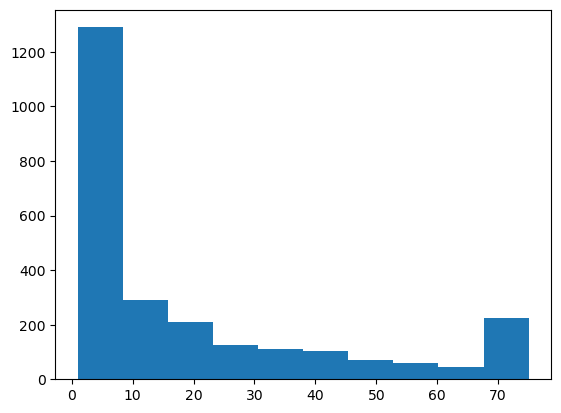

In [42]:
plt.hist([len(track) for track in tracks])